In [1]:
# importer le notebook des fonctions utiles et des importations nécessaires
import sys
sys.path.append('../utils')


In [2]:
from functions_and_imports import *

c:\Users\adri\Desktop\sepsis_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv('data/df_12H_imputed_with_knn.csv')

In [4]:
display_basic_info(data)

Shape of the DataFrame: (52536, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 SepsisLabel
0.0    39402
1.0    13134
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                float64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP         

In [5]:
# Convertir les colonnes 'Gender' et 'SepsisLabel' en entier
data['Gender'] = data['Gender'].astype(int)
data['SepsisLabel'] = data['SepsisLabel'].astype(int)
data['Patient_ID'] = data['Patient_ID'].astype(int)
data['Hour'] = data['Hour'].astype(int)
data.head(13)


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,SepsisLabel,Patient_ID,will_have_sepsis
0,242,135.0,97.0,38.670,136.0,101.0,82.0,31.0,29.9,4.0,...,32.44,11.50,352.2,524.2,27.92,1,-0.03,0,9,1.0
1,243,129.0,98.0,38.022,139.0,105.0,85.0,29.0,29.9,4.0,...,31.42,11.50,352.2,524.2,27.92,1,-0.03,0,9,1.0
2,244,122.0,99.0,38.060,136.0,105.0,86.0,28.0,31.7,4.0,...,32.44,11.50,352.2,469.2,27.92,1,-0.03,0,9,1.0
3,245,121.0,98.0,37.956,140.0,109.0,89.0,28.0,22.4,2.0,...,30.14,14.40,374.4,759.0,27.92,1,-0.03,0,9,1.0
4,246,115.0,98.0,37.720,139.0,105.0,85.0,27.0,31.3,0.0,...,28.42,11.50,330.0,487.0,27.92,1,-0.03,0,9,1.0
5,247,113.0,97.0,37.766,134.0,101.0,81.0,26.0,29.9,4.0,...,31.42,11.50,352.2,524.2,27.92,1,-0.03,0,9,1.0
6,248,119.0,100.0,37.940,140.0,106.0,85.0,26.5,31.7,4.0,...,32.44,11.50,352.2,469.2,27.92,1,-0.03,1,9,1.0
7,249,118.0,96.0,37.766,138.0,108.0,88.0,26.0,29.9,4.0,...,31.42,11.50,352.2,524.2,27.92,1,-0.03,1,9,1.0
8,250,111.0,97.0,37.390,136.0,106.0,86.0,26.0,29.9,4.0,...,32.44,11.50,352.2,524.2,27.92,1,-0.03,1,9,1.0
9,251,116.0,96.0,37.720,143.0,109.0,88.0,30.0,29.9,4.0,...,32.44,11.50,352.2,524.2,27.92,1,-0.03,1,9,1.0


In [6]:
# Filtrer les patients qui n'auront pas de sepsis (will_have_sepsis = 0)
non_sepsis_df = data[data['will_have_sepsis'] == 0]

# Garder les 6 dernières observations pour chaque patient
non_sepsis_df_reduced = non_sepsis_df.groupby('Patient_ID').tail(6)

# Garder les observations pour les patients ayant du sepsis (will_have_sepsis = 1)
sepsis_df = data[data['will_have_sepsis'] == 1]

# Concaténer les deux datasets pour obtenir le dataset final
df_balanced = pd.concat([non_sepsis_df_reduced, sepsis_df])


In [7]:
display_basic_info(df_balanced)

Shape of the DataFrame: (39402, 39)

Number of unique patients: 4378

SepsisLabel class counts:
 SepsisLabel
0    26268
1    13134
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    2189
1.0    2189
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP             

In [8]:
train_df, test_df  = split_train_test_data_v2(df_balanced)

In [9]:
display_basic_info(train_df)

Shape of the DataFrame: (31458, 39)

Number of unique patients: 3502

SepsisLabel class counts:
 SepsisLabel
0    21012
1    10446
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    1761
1.0    1741
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP             

In [10]:
display_basic_info(test_df)

Shape of the DataFrame: (7944, 39)

Number of unique patients: 876

SepsisLabel class counts:
 SepsisLabel
0    5256
1    2688
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    428
1.0    448
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 fl

In [11]:
# Pour chaque patient ayant 'will_have_sepsis' à 1, ne garder que les observations où 'SepsisLabel' est à 0
sepsis_train_df = train_df[(train_df['will_have_sepsis'] == 1) & (train_df['SepsisLabel'] == 1)]
non_sepsis_train_df = train_df[train_df['will_have_sepsis'] == 0]
df_train_balanced = pd.concat([non_sepsis_train_df, sepsis_train_df])

sepsis_test_df = test_df[(test_df['will_have_sepsis'] == 1) & (test_df['SepsisLabel'] == 0)]
non_sepsis_test_df = test_df[test_df['will_have_sepsis'] == 0]
df_test_balanced = pd.concat([non_sepsis_test_df, sepsis_test_df])

In [12]:
display_basic_info(df_train_balanced)

Shape of the DataFrame: (21012, 39)

Number of unique patients: 3502

SepsisLabel class counts:
 SepsisLabel
0    10566
1    10446
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    1761
1.0    1741
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP             

In [13]:
# Pour les patients ayant 'will_have_sepsis' à 1, mettre 'SepsisLabel' à 1
df_test_balanced.loc[df_test_balanced['will_have_sepsis'] == 1, 'SepsisLabel'] = 1


In [14]:
display_basic_info(df_test_balanced)

Shape of the DataFrame: (5256, 39)

Number of unique patients: 876

SepsisLabel class counts:
 SepsisLabel
1    2688
0    2568
Name: count, dtype: int64

Number of unique patients per class in 'will_have_sepsis':
 will_have_sepsis
0.0    428
1.0    448
Name: Patient_ID, dtype: int64

Columns in the DataFrame:
 Index(['Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'TroponinI', 'Hct', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'SepsisLabel', 'Patient_ID',
       'will_have_sepsis'],
      dtype='object')

Data Types:
 Hour                  int64
HR                  float64
O2Sat               float64
Temp                float64
SBP                 float64
MAP                 float64
DBP                 fl

In [15]:
test_df[test_df['Patient_ID'] == 119749].head(12)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,PTT,WBC,Fibrinogen,Platelets,Age,Gender,HospAdmTime,SepsisLabel,Patient_ID,will_have_sepsis
26088,153,98.0,86.0,36.50,130.0,82.0,64.0,37.0,40.2,-2.77,...,32.40,12.70,308.8,104.0,71.0,0,-30.59,0,119749,1.0
26089,154,93.0,96.0,36.60,132.0,85.0,68.0,30.0,39.9,-2.31,...,30.52,13.18,283.6,150.0,71.0,0,-30.59,0,119749,1.0
26090,155,107.0,97.0,36.40,95.0,65.0,52.0,31.5,36.5,-2.88,...,30.52,13.60,283.6,131.6,71.0,0,-30.59,0,119749,1.0
26091,156,94.0,99.0,36.20,100.0,66.0,52.0,32.0,36.5,-1.88,...,31.22,14.00,276.4,128.6,71.0,0,-30.59,0,119749,1.0
26092,157,94.0,97.0,36.20,116.5,76.5,62.0,32.5,39.7,-2.33,...,30.52,13.60,283.6,131.6,71.0,0,-30.59,0,119749,1.0
26093,158,93.0,86.0,36.35,116.0,74.5,59.0,33.0,39.7,-2.33,...,30.52,13.60,283.6,131.6,71.0,0,-30.59,0,119749,1.0
26094,159,93.0,91.0,37.30,143.0,83.0,64.0,37.0,39.9,-2.88,...,30.52,13.18,283.6,150.0,71.0,0,-30.59,1,119749,1.0
26095,160,94.0,85.0,37.00,124.0,75.0,59.0,32.0,39.7,-1.88,...,32.40,13.32,308.8,145.0,71.0,0,-30.59,1,119749,1.0
26096,161,96.0,89.0,36.50,120.0,76.0,61.0,34.3,39.7,-2.88,...,30.52,13.60,283.6,131.6,71.0,0,-30.59,1,119749,1.0
26097,162,95.0,90.0,36.30,113.0,82.0,67.0,36.0,39.7,-2.79,...,31.22,14.00,276.4,128.6,71.0,0,-30.59,1,119749,1.0


In [16]:
df_train_balanced.drop(columns='will_have_sepsis', inplace=True)
df_test_balanced.drop(columns='will_have_sepsis', inplace=True)

X_train = df_train_balanced.drop(columns='SepsisLabel')
y_train = df_train_balanced['SepsisLabel']

X_test = df_test_balanced.drop(columns='SepsisLabel')
y_test = df_test_balanced['SepsisLabel']

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21012, 37), (21012,), (5256, 37), (5256,))

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def objective(trial, X, y, cv=7):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_loguniform('gamma', 0.01, 1)
    subsample = trial.suggest_uniform('subsample', 0.5, 1)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-5, 1)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-5, 1)
    scale_pos_weight = trial.suggest_loguniform('scale_pos_weight', 0.1, 10)

    clf = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )

    score = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')  # Utilisation de roc_auc pour les données déséquilibrées
    return np.mean(score)


def perform_hyperparameter_optimization(X, y, objective, n_trials=50, random_state=42):
    """
    Crée une étude Optuna pour optimiser les hyperparamètres d'un modèle de machine learning.

    Args:
    X (DataFrame): Les features d'entrée pour le modèle.
    y (Series): Les étiquettes cibles.
    objective (function): La fonction objective pour Optuna.
    n_trials (int): Le nombre de tentatives d'optimisation.
    random_state (int): Graine pour la génération de nombres aléatoires pour la reproductibilité.

    Returns:
    dict: Meilleurs hyperparamètres trouvés par l'étude Optuna.
    """
    # Création d'un objet study d'Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))

    # Lancement de l'optimisation
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Retourne les meilleurs paramètres trouvés
    return study.best_params, study


def train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path):
    """
    Crée, entraîne et sauvegarde un modèle XGBoost avec des paramètres spécifiés.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    best_params (dict): Dictionnaire contenant les meilleurs paramètres pour le modèle.
    model_path (str): Chemin du fichier où le modèle sera sauvegardé.

    Returns:
    XGBClassifier: Le modèle XGBoost entraîné.
    """
    xgbc = XGBClassifier(
        n_jobs=-1,  # Utiliser tous les processeurs disponible
        tree_method='hist',  # Utiliser 'hist' pour accélérer l'entraînement
        subsample=0.8,       # Sous-échantillonnage pour réduire le temps d'entraînement
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        #subsample=best_params['subsample'],
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    )

    # Entraînement du modèle
    xgbc.fit(X_train, y_train)

    # Sauvegarde du modèle
    with open(model_path, 'wb') as file:
        pickle.dump(xgbc, file)

    return xgbc

def predict_and_evaluate_v2(model, X_test, y_test):
    """
    Fait des prédictions avec un modèle donné et évalue les résultats.

    Args:
    model (XGBClassifier): Le modèle entraîné à utiliser pour les prédictions.
    X_test (DataFrame): Les features de test.
    y_test (Series): Les étiquettes cibles de test.

    Returns:
    str: Un rapport d'évaluation imprimable.
    """
    # Prédiction avec le modèle
    y_predicted = model.predict(X_test)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_predicted)

    # Affichage de la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion')
    plt.show()

    # Génération du rapport d'évaluation
    evaluation_report = classification_report(y_test, y_predicted)

    return y_predicted, evaluation_report


In [22]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import numpy as np
import pickle

def perform_grid_search(X_train, y_train, param_grid, cv=7, scoring='accuracy', n_jobs=-1):
    """
    Effectue une recherche par grille pour optimiser les hyperparamètres d'un modèle XGBoost.

    Args:
    X_train (DataFrame): Les features d'entraînement.
    y_train (Series): Les étiquettes cibles d'entraînement.
    param_grid (dict): Grille des hyperparamètres à tester.
    cv (int): Nombre de plis pour la validation croisée.
    scoring (str): Métrique à optimiser.
    n_jobs (int): Nombre de cœurs à utiliser pour l'entraînement (-1 pour tous les cœurs).

    Returns:
    dict: Meilleurs hyperparamètres trouvés par la recherche par grille.
    GridSearchCV: L'objet `GridSearchCV` entraîné.
    """
    # Initialisation du modèle
    xgbc = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Initialisation de GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgbc,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        verbose=2
    )

    # Entraînement de GridSearchCV
    grid_search.fit(X_train, y_train)

    # Affichage des meilleurs hyperparamètres
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)

    return grid_search.best_params_, grid_search


# Modèle après suppression des colonnes : Hour et Patient_ID

In [25]:
X_train.drop(columns='Hour', inplace=True)
X_test.drop(columns='Hour', inplace=True)

X_train.drop(columns='Patient_ID', inplace=True)
X_test.drop(columns='Patient_ID', inplace=True)

KeyError: "['Hour'] not found in axis"

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21012, 35), (21012,), (5256, 35), (5256,))

In [28]:
study_filename = 'sauvegarde/params/optuna_study_6h.pkl'


In [26]:
# Calcule des meilleurs hyperparamètres
best_params, study = perform_hyperparameter_optimization(X_train, y_train, objective, n_trials=30)
print("Meilleurs hyperparamètres:", best_params)
save_study(study, study_filename)

[I 2025-02-12 23:55:59,681] A new study created in memory with name: no-name-c5e89c04-2f54-4acd-bbc1-150f6223803a
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

KeyboardInterrupt: 

In [29]:
study = load_study(study_filename)
best_params = study.best_params

In [30]:
# Entrainement du modèle avec les meilleurs hyperparamètres calculés
model_path = 'sauvegarde/models/xgboost_model_6h.joblib'
xgbc_model = train_and_save_xgboost_classifier(X_train, y_train, best_params, model_path)

c:\Users\adri\Desktop\sepsis_prediction\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:01:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


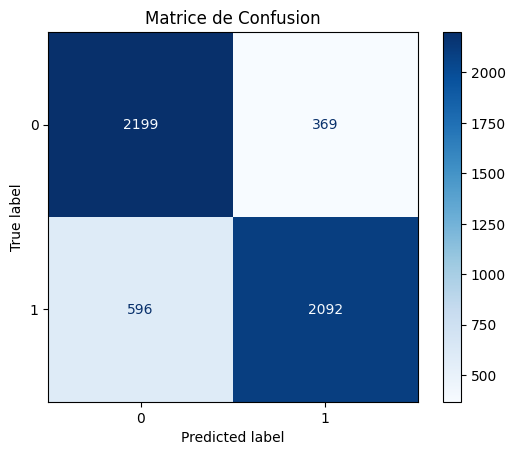

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2568
           1       0.85      0.78      0.81      2688

    accuracy                           0.82      5256
   macro avg       0.82      0.82      0.82      5256
weighted avg       0.82      0.82      0.82      5256



In [31]:
# Prédiction et évaluation
predictions, evaluation_report = predict_and_evaluate_v2(xgbc_model, X_test, y_test)
print(evaluation_report)

In [32]:
predictions[predictions==y_test].shape[0] / y_test.shape[0]

0.816400304414003

 98%|===================| 5154/5256 [00:43<00:00]        

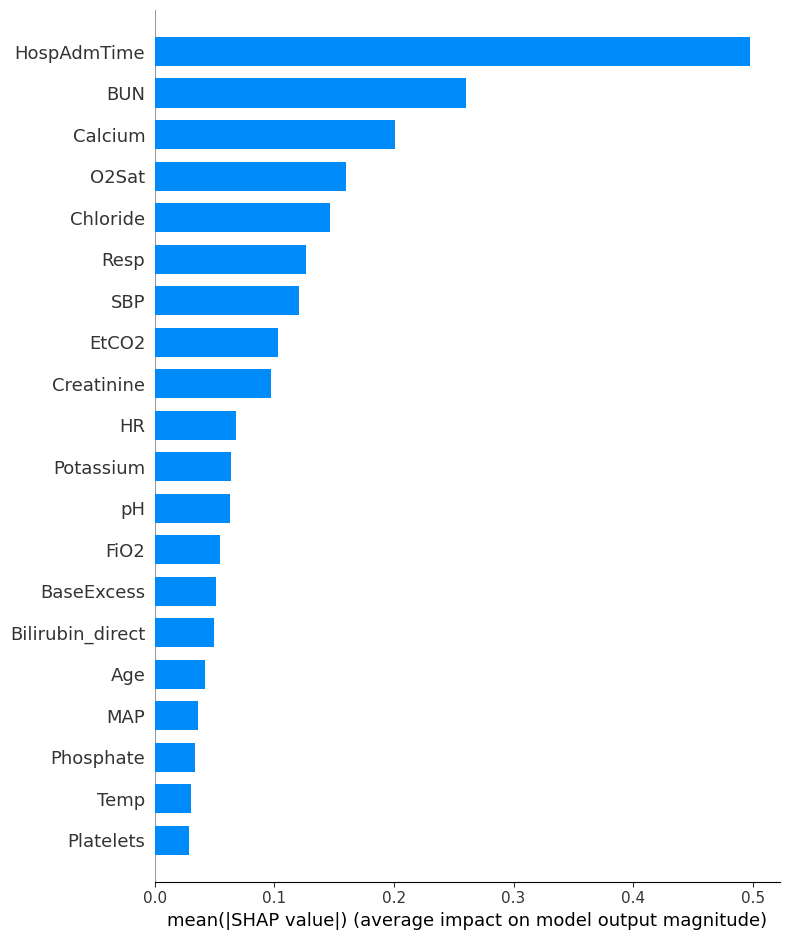

In [33]:
# Affichage du résultat de SHAP
explain_model_predictions_with_shap(xgbc_model, X_train, X_test)

In [34]:
features = [col for col in train_df.columns if col not in ['Patient_ID', 'Hour', 'SepsisLabel', 'will_have_sepsis']]

In [35]:
import matplotlib.patheffects as path_effects
import cmcrameri.cm as cmc

def draw_patient_pred(data_array, text_array, prediction, auto_scale=True, max_color_scale=0.13, text_color="black", outline_text_color=None, cmap="bwr"):
	if auto_scale:
		# Calculate the absolute max value in data_array to set symmetric color limits
		abs_max = max(abs(data_array.min()), abs(data_array.max()))
		vmin = -abs_max
		vmax = abs_max
	elif max_color_scale:
		# If max_color_scale is provided, use these values for the color limits
		vmin = -max_color_scale
		vmax = max_color_scale
	else:
		# Fallback to default behavior if neither auto_scale nor max_color_scale are specified
		abs_max = max(abs(data_array.min()), abs(data_array.max()))
		vmin = -abs_max
		vmax = abs_max

	plt.figure(figsize=(70, 6))  # Adjust the figure size as needed

	plt.title(f"Predicted sepsis: {prediction >= threshold} ({prediction})", fontsize=38)
	ax = sns.heatmap(data_array, annot=text_array, xticklabels=features, fmt=".2f",
					 annot_kws={"color": text_color, "fontsize": 22}, cmap=cmap , cbar=True,
					 cbar_kws={"shrink": 1.5, "aspect": 10, "label": "shap value (feature impact on sepsis prediction)"},
					 vmin=vmin, vmax=vmax)  # Set symmetric color limits based on abs max if auto_scale is True

	# Adjust the size of the color bar label for better readability
	ax.figure.axes[-1].yaxis.label.set_size(20)

	# outline values text
	if outline_text_color is not None:
		for text in ax.texts:  # `ax.texts` contains all annotations
			text.set_path_effects([
				path_effects.Stroke(linewidth=2, foreground=cmap),
				path_effects.Normal()  # Normal text appearance
			])

	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=24)
	ax.xaxis.set_ticks_position("top")  # Place x-ticks on top
	ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

	plt.show()


In [36]:
def extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6):
	"""
	Prépare les données d'entraînement et de test pour l'extraction de séquences
	"""
	# column will_have_sepsis is dropped earlier in the notebook, so no attempt is made here.
	# Sélectionner les colonnes de caractéristiques
	feature_cols = [col for col in train_df.columns if col not in exclude_columns]

	return extract_sequences_and_labels(
		test_df, id_column, time_column, feature_cols, label_column, sequence_length
	)

In [37]:
original_sequences, _ = extract_sequences(test_df, exclude_columns=['Patient_ID', 'Hour', 'Sepsispredicted','SepsisLabel'], label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

In [38]:
data_to_explain = X_test[:]  # Example: Take the first 10 samples from the validation set

In [39]:
explainer = shap.Explainer(xgbc_model, X_train)


In [40]:
features = [col for col in train_df.columns if col not in ['Patient_ID', 'Hour', 'SepsisLabel', 'will_have_sepsis']]

In [41]:
shap_values_all = np.array(explainer.shap_values(data_to_explain)).reshape(-1, 35)


 98%|===================| 5145/5256 [00:42<00:00]        

In [42]:
with open('sauvegarde/shap_values/xgboost_shap.pkl', 'wb') as f:
    pickle.dump(shap_values_all, f)

xgbc_model.save_model('sauvegarde/models/xgboost_model.json')

In [57]:
with open('sauvegarde/shap_values/xgboost_shap.pkl', 'rb') as f:
	shap_values_all = pickle.load(f)

xgbc_model = XGBClassifier()
xgbc_model.load_model('sauvegarde/models/xgboost_model.json')

In [43]:
y_test

26298    0
26299    0
26300    0
26301    0
26302    0
        ..
26089    1
26090    1
26091    1
26092    1
26093    1
Name: SepsisLabel, Length: 5256, dtype: int64

In [44]:
data_to_explain.shape

(5256, 35)

In [45]:
trueLabels = y_test.values

In [46]:
shap_values_all.shape

(5256, 35)

In [47]:
X_test_arr = X_test.values

In [48]:
X_test_arr.shape

(5256, 35)

In [49]:
(predictions==trueLabels).mean()

np.float64(0.816400304414003)

In [50]:
predictions.shape

(5256,)

In [51]:
for i in range(1,int(len(predictions))):
	if predictions[i] != predictions[i-1]:
		print(i,"change")
	if predictions[i] != trueLabels[i]:
		print(i,"diff")

9 change
9 diff
10 diff
11 diff
12 diff
13 diff
14 diff
15 diff
16 diff
17 diff
18 change
49 change
49 diff
50 diff
51 change
52 change
52 diff
53 diff
54 change
92 change
92 diff
93 change
104 change
104 diff
105 diff
106 diff
107 diff
108 change
120 change
120 diff
121 diff
122 diff
123 diff
124 diff
125 diff
126 change
134 change
134 diff
135 diff
136 diff
137 change
203 change
203 diff
204 diff
205 diff
206 diff
207 diff
208 diff
209 diff
210 change
291 change
291 diff
292 change
306 change
306 diff
307 diff
308 change
309 change
309 diff
310 diff
311 diff
312 change
315 change
315 diff
316 diff
317 diff
318 change
336 change
336 diff
337 diff
338 change
354 change
354 diff
355 diff
356 diff
357 diff
358 diff
359 diff
360 change
367 change
367 diff
368 change
370 change
370 diff
371 diff
372 change
376 change
376 diff
377 change
383 change
383 diff
384 change
407 change
407 diff
408 change
429 change
429 diff
430 diff
431 change
492 change
492 diff
493 change
547 change
547 diff
54

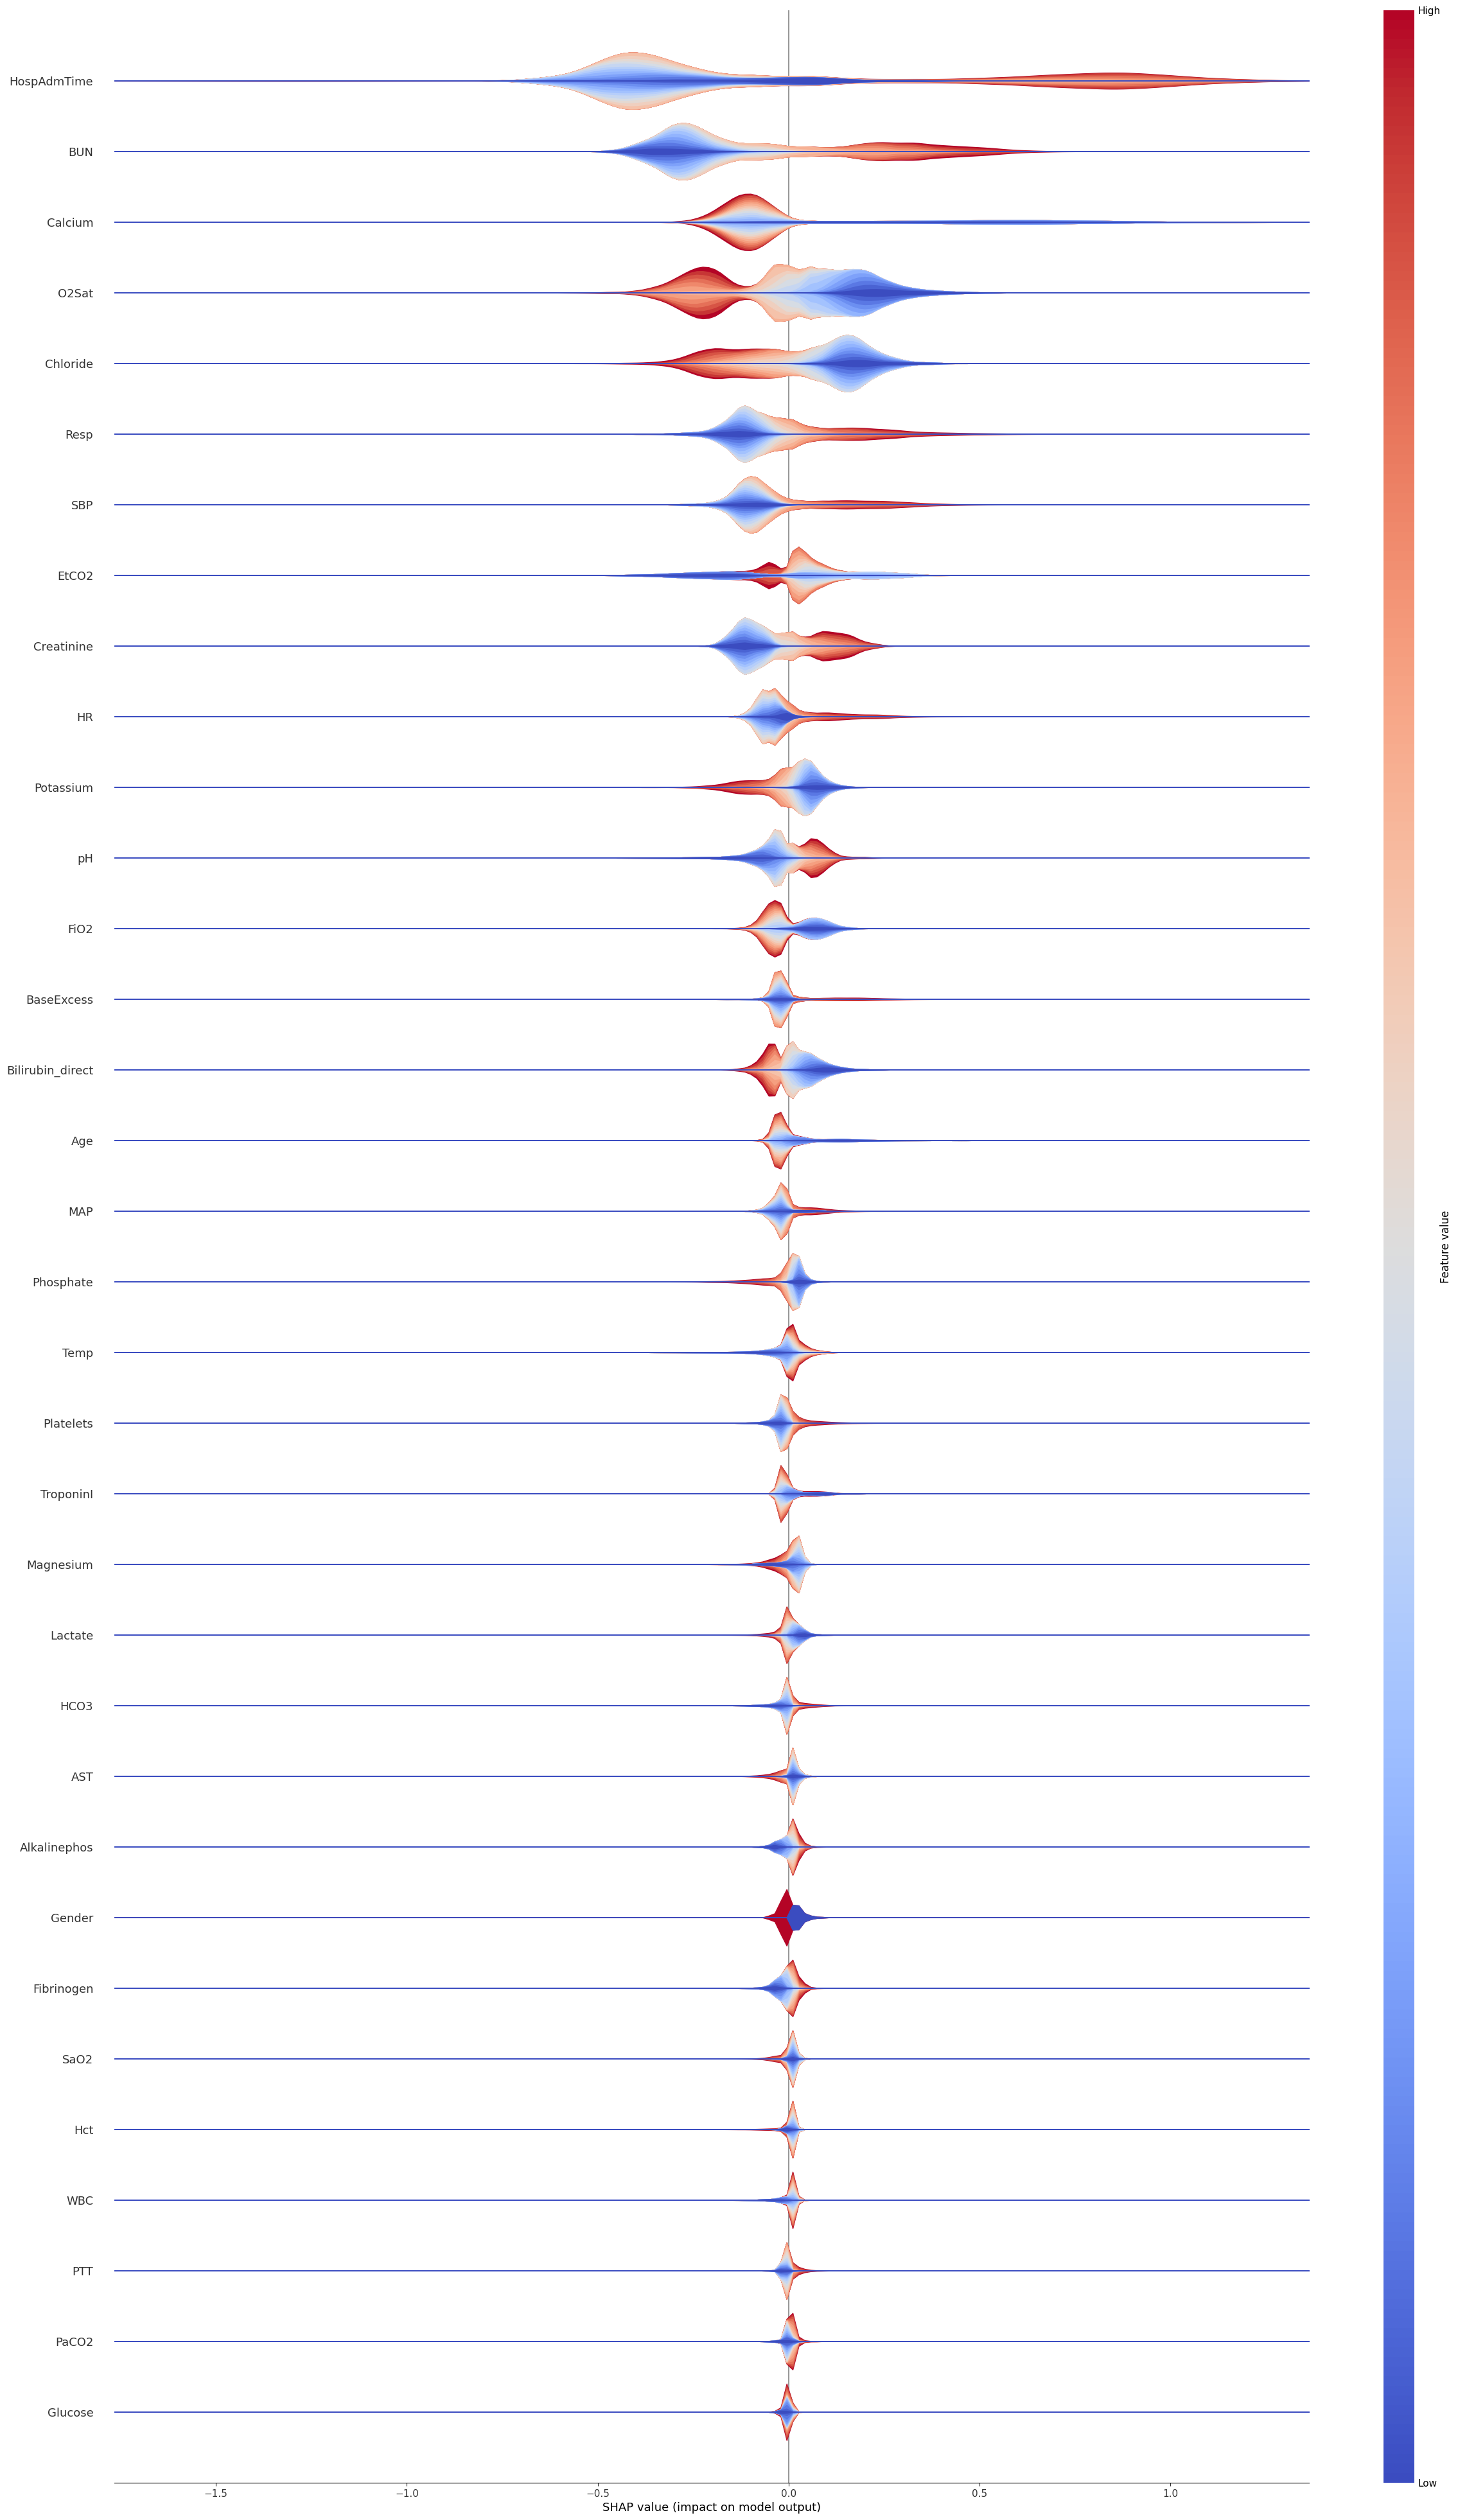

In [52]:
shap.plots.violin(shap_values_all, features=X_test[:shap_values_all.shape[0]], feature_names=features, max_display=-1, plot_type="layered_violin", plot_size=(30, 50))

In [53]:
exp = explainer(data_to_explain[12:18])

In [54]:
print(exp.values.shape)

(6, 35)


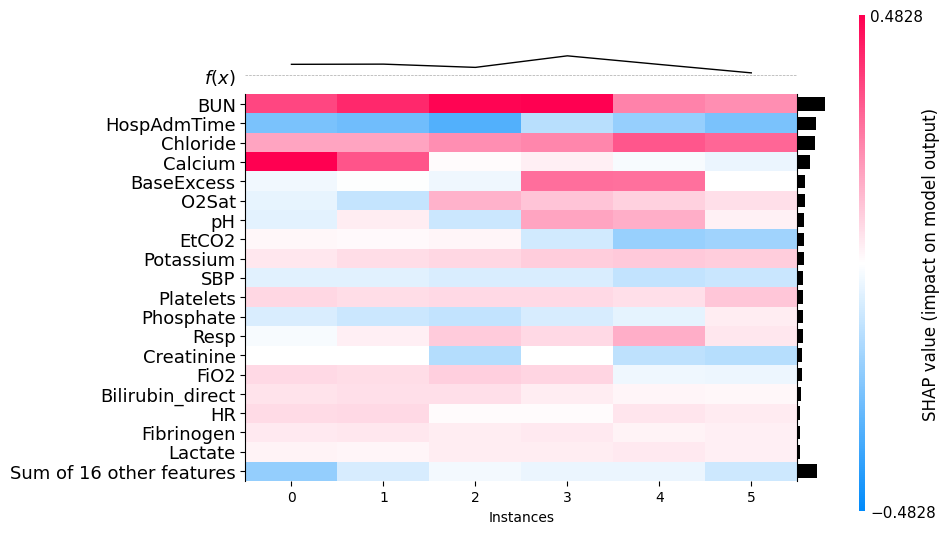

<Axes: xlabel='Instances'>

In [55]:
shap.plots.heatmap(exp, max_display=20)

Patient 2, lines 12 to 17, sepsis labels: [0 0 0 0 0 0]


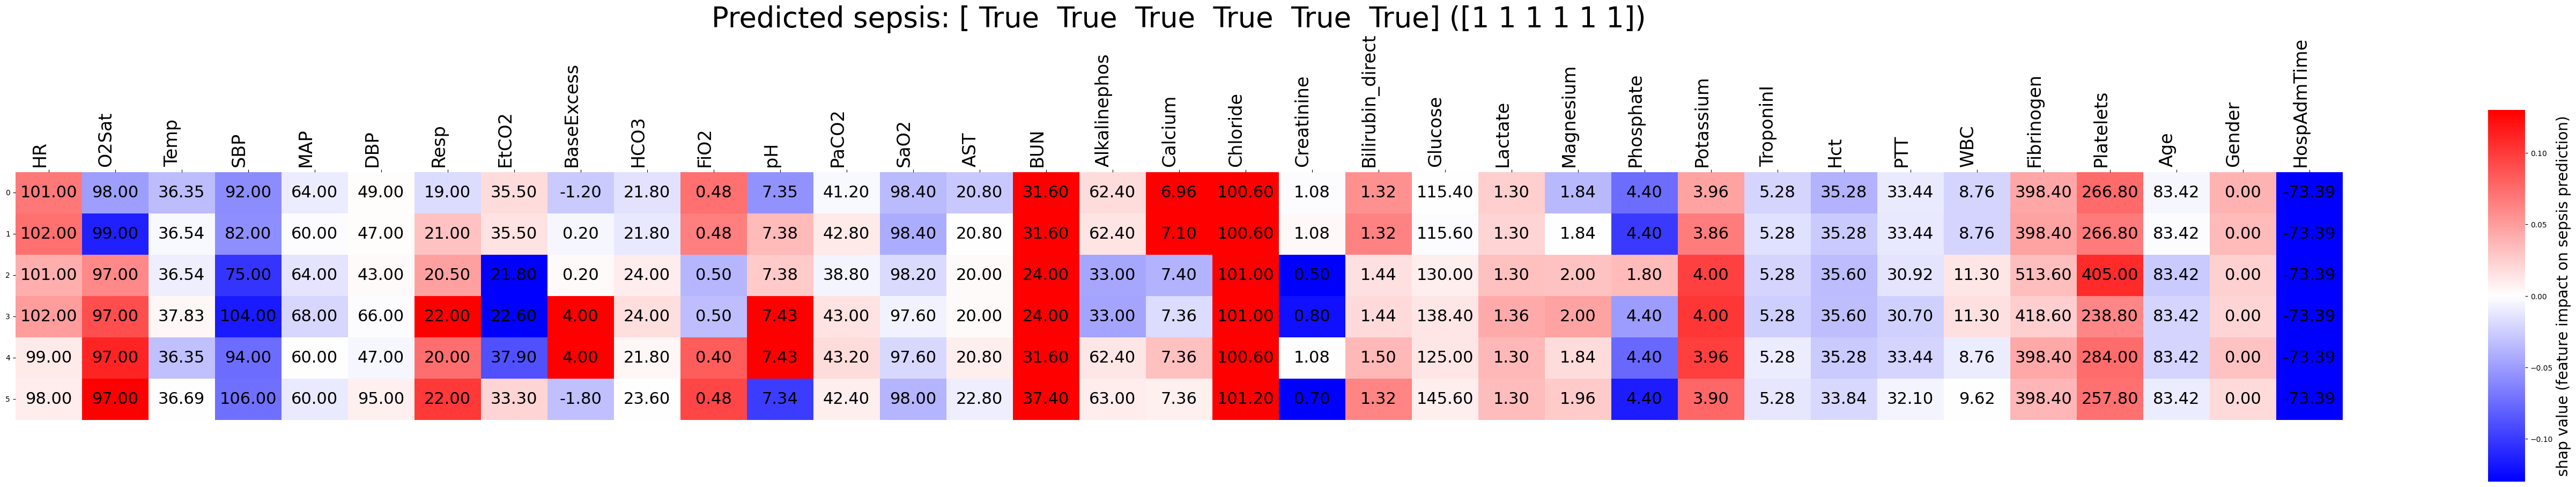

In [56]:
threshold = 0.7
patient=2 # = 27 for other notebooks apparently
start=6*patient
end=6*patient+6
print(f"Patient {patient}, lines {start} to {end-1}, sepsis labels:", trueLabels[start:end])
# print("sepsis predicted:", predictions[i] >= threshold, f'({predictions[i]:.4f})')
data_array = shap_values_all[start:end]
text_array = X_test_arr[start:end]
draw_patient_pred(data_array, text_array, predictions[start:end], auto_scale=False)